In [35]:
# adapted from Zijin Gu: https://github.com/zijin-gu/scfc-coupling
import scipy.io as sio
import numpy as np
import os

cwd = os.getcwd()
data_dir = str(cwd)
roi_number = 268

def extract_fc_corr(session):
    fc_dir = data_dir +'/pearson_fc/'
    subj_all = np.genfromtxt(fc_dir + 'subjects.txt', dtype = 'str')
    fc_corr = np.zeros([subj_all.shape[0],roi_number,roi_number])
    n = 0
    for subj in subj_all:
        fccov = sio.loadmat(fc_dir + str(subj))
        fc_corr[n] = fccov['C']
        n += 1
    mdic = {"C": fc_corr}
    sio.savemat(strcat(data_dir + 'FCcorr_concat_allsub.mat'), mdic)

def extract_fc_prec():
    fc_dir =data_dir + '/covariance/'
    subj_all = np.genfromtxt(fc_dir + 'subjects.txt', dtype = 'str')
    fc_corr = np.zeros([subj_all.shape[0],roi_number,roi_number])
    n = 0
    for subj in subj_all:
        fccov = sio.loadmat(fc_dir + str(subj))
        fc_corr[n] = fccov['C'] # need to use normalized correlation (covariance)
        n += 1

    # regularized precision calculation
    min_rmse = 1e5
    opt_gamma = 0
    allrmse=[]
    for gamma in np.linspace(0,1,51):
        inverse = []
        reg_inv = []
        for i in range(subj_all.shape[0]):
            np.fill_diagonal(fc_corr[i],1)
            inverse.append(np.linalg.inv(fc_corr[i]))
            reg_inv.append(np.linalg.inv(fc_corr[i] + gamma*np.eye(roi_number)))
        group_prec = np.mean(inverse, axis=0)
        diff = []
        for i in range(subj_all.shape[0]):
            diff.append(np.linalg.norm(reg_inv[i][np.triu_indices(roi_number,1)] - group_prec[np.triu_indices(roi_number,1)]))
        rmse = np.mean(diff)
        allrmse.append(rmse)
        if rmse < min_rmse:
            min_rmse = rmse
            opt_gamma = gamma

    fc_prec = np.zeros([subj_all.shape[0],roi_number,roi_number])
    for i in range(subj_all.shape[0]):
        fc_prec[i] = np.linalg.inv(fc_corr[i] + opt_gamma*np.eye(roi_number))

    mdic = {"C": fc_prec, "gamma": opt_gamma, "rmse":allrmse}
    sio.savemat(fc_dir + 'FCprec_concat_allsub.mat', mdic)

for sess in range(0,5):
    extract_fc_prec()
    extract_fc_corr()

229
229
229
229
229


Text(0.5, 1.0, 'Grid search for optimal regularization parameter (gamma)')

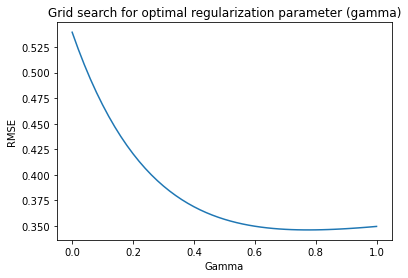

In [49]:
import matplotlib.pyplot as plt

cwd = os.getcwd()
data_dir = str(cwd)
fc_dir =data_dir + '/covariance/'
output_prec = sio.loadmat(fc_dir + 'FCprec_concat_allsub.mat')
rmse = output_prec['rmse'] # need to use normalized correlation (covariance)
gridsearch=np.linspace(0,1,51)

plt.plot(gridsearch,rmse.transpose())
plt.ylabel('RMSE')
plt.xlabel('Gamma')
plt.title('Regularization parameter (gamma)')

In [29]:
print(np.linspace(0,1,51))

[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


In [ ]:
«